# Pade approximation for FRB DM cosmic

### Packages & Constants

In this section, we are loading the basic modules of interest, and define our constants and basic functions.

In [1]:
### Arrays, vectorisation & special functions ###
import numpy as np
from scipy.integrate import quad
from scipy.special import hyp2f1
import scipy.constants as const

from numpy.random import default_rng
rng = default_rng(seed=1)

### Plots and Styling ###
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import cm, ticker
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

font = 'Times New Roman'
font_size = 14
rcParams['font.size']= font_size
rcParams['font.family'] = font
rcParams['mathtext.fontset'] = 'dejavuserif'

### Astropy Package - for cosmological calculations ###
from astropy.cosmology import FlatLambdaCDM

In [2]:
SAVE_FIG = True

__Useful constants__

In [3]:
f_IGM = 0.84
OMEGA_BARYONS = 0.04897
PI = const.pi
C_LIGHT = const.c
G_NEWTON = const.G
M_PROTON = const.m_p

##########################
### Define cosmo model ###
##########################

# We assume a flat, FRW universe.
OMEGA_MATTER = 0.30966 
HUBBLE = 67.66
cosmo_model = FlatLambdaCDM(H0=HUBBLE, Om0=OMEGA_MATTER)

## Basic definitions <a name="Definitions"></a>

We are defining the **luminosity distance**, observed through GWs:

$$
d_L = (1+z) \frac{c}{H_0} \int_0^z \frac{dz}{\sqrt{\Omega_m(1+z)^3+(1-\Omega_m)}} = d^0_L \cdot (1+z) \cdot f(z).
$$

We are defining the diffuse **dispersion measure (DM)**, based on [[Deng & Zhang, 2014](https://iopscience.iop.org/article/10.1088/2041-8205/783/2/L35/pdf)], eq. (13) and eq. (12) of [[arXiv:1805.12265](https://arxiv.org/abs/1805.12265)], for a flat $\Lambda$CDM:

$$
{\rm DM}_{\rm diff} = \frac{3 c H_0 \Omega_b f_{\rm IGM}}{8 \pi G m_p} \chi_{7/8} \int_0^z \frac{ (1+z) dz}{\sqrt{\Omega_m(1+z)^3+(1-\Omega_m)}} = {\rm DM}_{\rm diff}^0 \cdot g(z).
$$


Assuming redshifts $z<2$, we use $\chi_{7/8} \simeq 7/8$ - this assumes that the Universe is fully ionised at that time.

In [4]:
# Define the two integrands - we will use them for numerical integration

def dL_integrand(z, Om):
    """
    Function that it inside the integral of the DL formula.
    
    Input
    ----------
    z : redshift
    Om: Omega matter
    """
    return 1/np.sqrt(Om*(1+z)**3+1-Om)


def dDM_integrand(z, Om):
    """
    Function that it inside the integral of the DM formula.
    
    Input
    ----------
    z : redshift
    Om: Omega matter
    """
    return (1+z)/(np.sqrt(Om*(1+z)**3+1-Om))


def dDM_integrand_wCDM(z, Om, w):
    """
    Function that it inside the integral of the DM formula.
    
    Input
    ----------
    z : redshift
    Om: Omega matter
    w: dark energy EoS
    """
    return (1+z)/(np.sqrt(Om*(1+z)**3+(1-Om)*(1+z)**(3+3*w)))

In [5]:
########################################################
### Functions to calculate the integrals numerically ###
########################################################

def DL_distance(z, Om):
    """
    Calculates the integral in the DL formulae,
    for a given pair of (z, Om).
    
    Input
    ----------
    z : `float`
        redshift
    Om : Omega_matter
    
    Returns
    ----------
    integral : `float`
        integral value for (z, Om) pair for DL distance
    """

    integral = quad(dL_integrand, 0, z, args=(Om))[0]
    
    return (1+z)*integral


def DM_distance(z, Om):
    """
    Calculates the integral in the DM formulae,
    for a given pair of (z, Om).
    
    Input
    ----------
    z : `float`
        redshift
    Om : Omega_matter
    
    Returns
    ----------
    integral : `float`
        integral value for (z, Om) pair for DM distance
    """
    integral = quad(dDM_integrand, 0, z, args=(Om))[0]
    
    return integral


def DM_distance_wCDM(z, Om, w):
    """
    Calculates the integral in the DM formulae,
    for a given values of (z, Om, w).
    
    Input
    ----------
    z : `float`
        redshift
    Om : Omega_matter
    w : Dark energy EoS
    
    Returns
    ----------
    integral : `float`
        integral value for (z, Om, w) triplet for DM distance
    """
    integral = quad(dDM_integrand_wCDM, 0, z, args=(Om, w))[0]
    
    return integral    


def DM_distance_hyp(z, Om):
    """
    Calculates the integral in the DM formulae,
    for a given pair of (z, Om), using the Gaussian
    hypergeometric function.
    
    Input
    ----------
    z : `float`
        redshift
    Om : Omega_matter
    
    Returns
    ----------
    integral : `float`
        integral value for (z, Om) pair for DM distance
    """

    factor_z = (z+1)**2/(2*np.sqrt(1-Om))
    factor_0 = 1/(2*np.sqrt(1-Om))

    argument = -Om*(1+z)**3/(1-Om)
    hyp_z = hyp2f1(1/2, 2/3, 5/3, argument)
    hyp_0 = hyp2f1(1/2, 2/3, 5/3, -Om/(1-Om))

    return factor_z*hyp_z-factor_0*hyp_0

In [6]:
# We integrate between z = [0, 2]
redshifts = np.linspace(0.01, 2.0, 200)

# Compare our luminosity distance integral with the result for AstroPy.

# Note: we need to multiply the AstroPy result with Ho/c,
# to make the units consistent for the comparison (Astropy uses km/s).

dL_astropy = (HUBBLE/(C_LIGHT/1e3))*cosmo_model.luminosity_distance(redshifts).value

We calculate the integrals for a:

- Flat, LCDM universe ($\Omega_m = 0.30966, \Omega_\Lambda = 1-\Omega_m$)
- Flat, MD universe ($\Omega_m = 1.0, \Omega_\Lambda = 1-\Omega_m$)
- Flat, LD universe ($\Omega_m \rightarrow 0.0, \Omega_\Lambda = 1-\Omega_m$)
- Flat, low $\Omega_m$ universe ($\Omega_m = 0.2, \Omega_\Lambda = 1-\Omega_m$)
- Flat, $w$CDM universe ($\Omega_m = \Omega_m^{\rm LCDM}, w = -3.0, -0.5$)

In [7]:
DM_LCDM_array = np.zeros_like(redshifts)
DL_LCDM_array = np.zeros_like(redshifts)
DM_MD_array = np.zeros_like(redshifts)
DL_MD_array = np.zeros_like(redshifts)
DM_LD_array = np.zeros_like(redshifts)
DL_LD_array = np.zeros_like(redshifts)

DM_lowOm_array = np.zeros_like(redshifts)
DL_lowOm_array = np.zeros_like(redshifts)

DM_wCDM30_array = np.zeros_like(redshifts)
DM_wCDM05_array = np.zeros_like(redshifts)

for i , z in enumerate(redshifts):
    DM_LCDM_array[i] = DM_distance(z, Om=OMEGA_MATTER)
    DL_LCDM_array[i] = DL_distance(z, Om=OMEGA_MATTER)
    DM_MD_array[i] = DM_distance(z, Om=1.0)
    DL_MD_array[i] = DL_distance(z, Om=1.0)
    DM_LD_array[i] = DM_distance(z, Om=0.01)
    DL_LD_array[i] = DL_distance(z, Om=0.01)
    DM_lowOm_array[i] = DM_distance(z, Om=0.2)
    DL_lowOm_array[i] = DL_distance(z, Om=0.2)
    DM_wCDM30_array[i] = DM_distance_wCDM(z, Om=OMEGA_MATTER, w=-3.0)
    DM_wCDM05_array[i] = DM_distance_wCDM(z, Om=OMEGA_MATTER, w=-0.5)

### Comparison with AstroPy

Comparing the `scipy` integraton with `AstroPy` results, in the LCDM case. The results seem consistent in very good \% agreement.

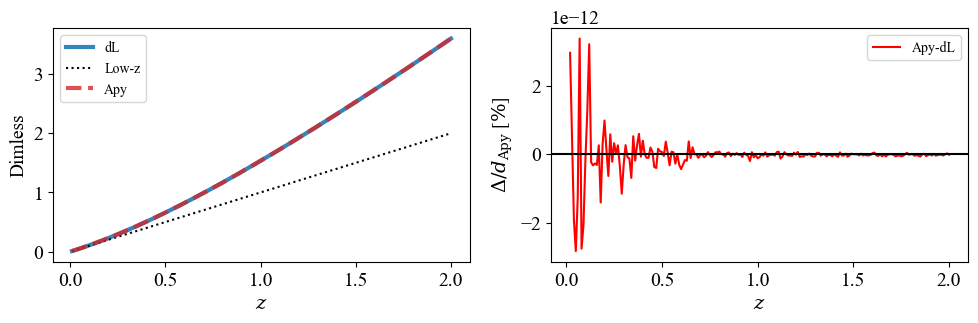

In [8]:
fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2)

ax1.plot(redshifts, DL_LCDM_array, label='dL', c='tab:blue', lw=3, alpha=0.9)
ax1.plot(redshifts, redshifts, label='Low-z', ls=':', c='black')
ax1.plot(redshifts, dL_astropy, label='Apy', ls='--', c='tab:red', lw=3, alpha=0.8)
ax1.set_xlabel(r'$z$')
ax1.set_ylabel(r'Dimless')
ax1.legend(fontsize=10)

ax2.plot(redshifts[1:], (dL_astropy[1:]-DL_LCDM_array[1:])/dL_astropy[1:]*100, label='Apy-dL', c='red')
ax2.axhline(y=0, c='black')
ax2.set_xlabel(r'$z$')
ax2.set_ylabel(r'$\Delta/d_{\rm Apy}$ [$\%$]')
ax2.legend(fontsize=10)

plt.tight_layout()
plt.show()

### Integrands comparison

Comparing just the integrands (i.e. we have removed any constants or astrophysical factors).

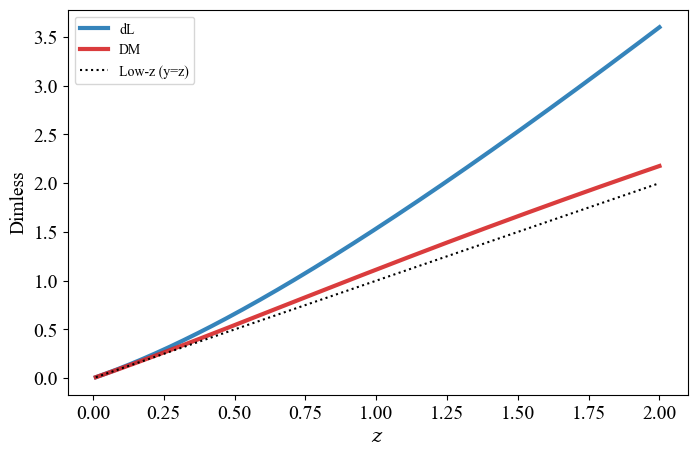

In [9]:
fig = plt.figure(figsize=(8, 5))
ax1 = fig.add_subplot(1, 1, 1)

ax1.plot(redshifts, DL_LCDM_array, label='dL', c='tab:blue', lw=3, alpha=0.9)
ax1.plot(redshifts, DM_LCDM_array, label='DM', c='tab:red', lw=3, alpha=0.9)
ax1.plot(redshifts, redshifts, label='Low-z (y=z)', ls=':', c='black')
ax1.set_xlabel(r'$z$')
ax1.set_ylabel(r'Dimless')
ax1.legend(fontsize=10)

plt.show()

### Investigating timing

__Timing__

In [10]:
import timeit

In [11]:
## z=0.5

print("\n Timing for DL -- astropy --:")
%timeit (HUBBLE/(C_LIGHT/1e3))*cosmo_model.luminosity_distance(0.5).value

print("\n Timing for DL -- quad --:")
%timeit DL_distance(0.5, Om=OMEGA_MATTER)

print("\n Timing for DM -- quad --:")
%timeit  DM_distance(0.5, Om=OMEGA_MATTER)


 Timing for DL -- astropy --:
71.8 μs ± 6.01 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)

 Timing for DL -- quad --:
41.6 μs ± 3.73 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)

 Timing for DM -- quad --:
44.4 μs ± 6.46 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


### Distance Approximants

To avoid costly integrations, it is possible to develop approximations for the different distances. The main idea behind these, is a series approximation of the integral, and then different "tricks" to retain good behaviour at all redshifts.

For all the distances we calculate the dimensionless values, i.e. ignoring any astrophysical/cosmological parameters which are just multiplying factors. The approximants for the luminosity distance are taken from [here](https://arxiv.org/pdf/1111.6396.pdf) and [here](https://arxiv.org/pdf/1003.0483.pdf).

A detailed derivation of the _Pade approximants_ can be found in the Appendix (at the end of the notebook).

In [12]:
########################################
### Luminosity Distance Approximants ###
########################################


#######################################
### Adachi-Kasai (pade) approximant ###
#######################################

def Phi(x):
    b1 = 4222975319/1599088274
    b2 = 1138125153117/1288865148844
    b3 = 7433983569773/139933930445920
    c1 = 635916643/456882364
    c2 = 14505955555/28326706568
    c3 = 44686179629/1133068262720
    
    return (2.0+b1*x+b2*x**2+b3*x**3)/(1.0+c1*x+c2*x**2+c3*x**3)
        
def x_phi(z, Om):
    return (1.-Om)/Om/(1.+z)**3
    
def dL_pade(z, Om):
    x0 = x_phi(0, Om)
    x = x_phi(z, Om)
    factor = (1.+z)/Om**(1/2)
    
    return factor*(Phi(x0)-Phi(x)/(1.+z)**(1/2))

In [13]:
################################
### DM Distance Approximants ###
################################

###########################
### DM Pade approximant ###
###########################

def PhiDM(x):
    b1 = -2.85592665
    b2 = -1.0945641
    b3 = -0.0913347
    c1 = 1.32796333
    c2 = 0.44857662
    c3 = 0.02769881
    
    return (-2.0+b1*x+b2*x**2+b3*x**3)/(1.0+c1*x+c2*x**2+c3*x**3)
        
def x_phiDM(z, Om):
    return (1.-Om)/Om/(1.+z)**3
    
def DM_pade(z, Om):
    x0 = x_phiDM(0, Om)
    x = x_phiDM(z, Om)
    factor = 1.0/Om**(1/2)
    
    return factor*(PhiDM(x0)-PhiDM(x)*(1.+z)**(1/2))


################################
### wCDM DM Pade approximant ###
################################

def PhiDM_wCDM(x, w):
    """ NOTE: Compared to previous definitions, here b_i are in the
    denominator and c_i in the numerator.
    """

    w2 = w**2
    w3 = w**3
    w4 = w**4
    w5 = w**5
    w6 = w**6
    w7 = w**7
    w8 = w**8
    w9 = w**9
    w10 = w**10
    w11 = w**11
    w12 = w**12
    
    b1 = 7*(13554501120*w7 + 2144869632*w6 + 186662880*w5 + 11424240*w4 + 447552*w3 + 10512*w2 + 138*w + 1)/(4*(17420977152*w7 + 2348289792*w6 + 206452800*w5 + 12398832*w4 + 473904*w3 + 10800*w2 + 144*w + 1))
    b2 = 7*(287698065408*w8 + 67349242368*w7 + 7092738432*w6 + 484856928*w5 + 23238576*w4 + 732672*w3 + 14328*w2 + 162*w + 1)/(8*(522629314560*w8 + 87869670912*w7 + 8541873792*w6 + 578417760*w5 + 26615952*w4 + 797904*w3 + 15120*w2 + 174*w + 1))
    b3 = 7*(3862337458176*w9 + 1485633788928*w8 + 219003450624*w7 + 17781674688*w6 + 976307904*w5 + 38712816*w4 + 1042416*w3 + 17892*w2 + 180*w + 1)/(64*(12543103549440*w9 + 2631501416448*w8 + 292874641920*w7 + 22423900032*w6 + 1217200608*w5 + 45765648*w4 + 1160784*w3 + 19296*w2 + 198*w + 1))
    c0 = 6*w
    c1 = 15*w*(113857809408*w8 + 30024815616*w7 + 3631469760*w6 + 274710528*w5 + 14793840*w4 + 525312*w3 + 11556*w2 + 144*w + 1)/(2*(104525862912*w8 + 31510715904*w7 + 3587006592*w6 + 280845792*w5 + 15242256*w4 + 538704*w3 + 11664*w2 + 150*w + 1))
    c2 = 9*w*(48333274988544*w10 + 15147986411520*w9 + 2611359461376*w8 + 276998911488*w7 + 19936155456*w6 + 1037489472*w5 + 39459312*w4 + 1036800*w3 + 17676*w2 + 180*w + 1)/(4*(37629310648320*w10 + 15733943967744*w9 + 2719298304000*w8 + 283269477888*w7 + 20869742016*w6 + 1114953984*w5 + 42066864*w4 + 1082592*w3 + 18324*w2 + 192*w + 1))
    c3 = 3*w*(35039125420572672*w12 + 8629966763753472*w11 + 1619918846263296*w10 + 221082842105856*w9 + 21477950191872*w8 + 1497341832192*w7 + 77109117696*w6 + 3001784832*w5 + 87399648*w4 + 1812672*w3 + 25200*w2 + 216*w + 1)/(32*(16255862200074240*w12 + 8377494841294848*w11 + 1873191824621568*w10 + 252316887183360*w9 + 23632344926208*w8 + 1641458763648*w7 + 85870694592*w6 + 3349442016*w5 + 95451696*w4 + 1935144*w3 + 26820*w2 + 234*w + 1))
    
    return (c0+c1*x+c2*x**2+c3*x**3)/(1.0+b1*x+b2*x**2+b3*x**3)
        
def x_phiDM_wCDM(z, Om, w):
    return (1.-Om)/Om*(1.+z)**(3*w)
    
def DM_pade_wCDM(z, Om, w):
    x0 = x_phiDM_wCDM(0, Om, w)
    x = x_phiDM_wCDM(z, Om, w)
    factor = -1.0/Om**(1/2)*(1/(3*w))
    
    return factor*(PhiDM_wCDM(x0, w)-PhiDM_wCDM(x, w)*(1.+z)**(1/2))    

__Approximant distance checks__

We check how well the approximants perform in terms of accuracy and timing. Note that these are _cosmology dependent_ (we comment on this at the end).

$dL$ distance checks (accuracy)

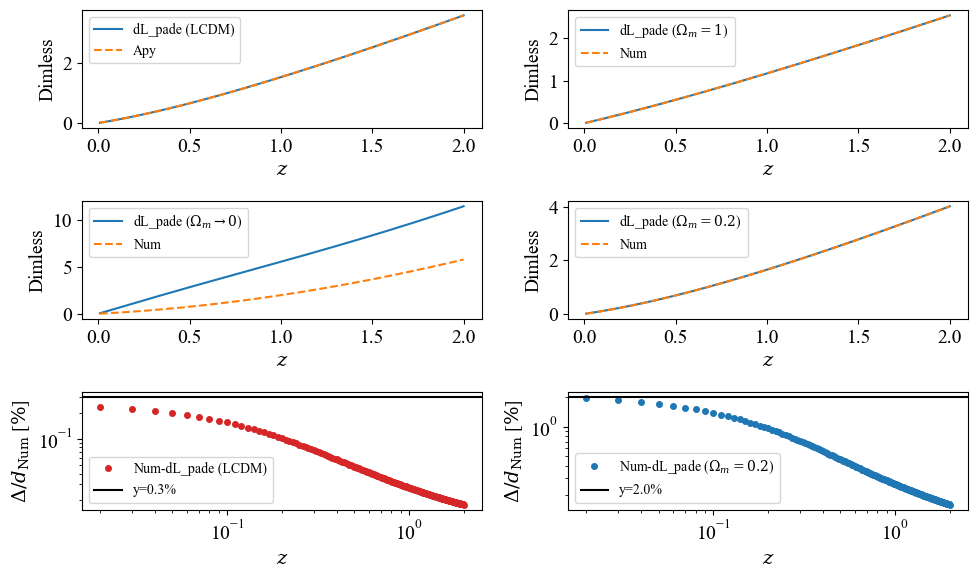

In [14]:
fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(3, 2, 1)
ax2 = fig.add_subplot(3, 2, 2)
ax3 = fig.add_subplot(3, 2, 3)
ax4 = fig.add_subplot(3, 2, 4)
ax5 = fig.add_subplot(3, 2, 5)
ax6 = fig.add_subplot(3, 2, 6)


ax1.plot(redshifts, dL_pade(redshifts, OMEGA_MATTER), label='dL_pade (LCDM)')
ax1.plot(redshifts, dL_astropy, label='Apy', ls='--')
ax1.set_xlabel(r'$z$')
ax1.set_ylabel(r'Dimless')
ax1.legend(fontsize=10)

ax2.plot(redshifts, dL_pade(redshifts, Om=1), label=r'dL_pade ($\Omega_m=1$)')
ax2.plot(redshifts, DL_MD_array, label='Num', ls='--')
ax2.set_xlabel(r'$z$')
ax2.set_ylabel(r'Dimless')
ax2.legend(fontsize=10)

ax3.plot(redshifts, dL_pade(redshifts, Om=0.01), label=r'dL_pade ($\Omega_m \rightarrow 0$)')
ax3.plot(redshifts, DL_LD_array, label='Num', ls='--')
ax3.set_xlabel(r'$z$')
ax3.set_ylabel(r'Dimless')
ax3.legend(fontsize=10)

ax4.plot(redshifts, dL_pade(redshifts, Om=0.2), label=r'dL_pade ($\Omega_m = 0.2$)')
ax4.plot(redshifts, DL_lowOm_array, label='Num', ls='--')
ax4.set_xlabel(r'$z$')
ax4.set_ylabel(r'Dimless')
ax4.legend(fontsize=10)

ax5.plot(redshifts[1:], np.abs((DL_LCDM_array[1:]-dL_pade(redshifts[1:], OMEGA_MATTER)))/(DL_LCDM_array[1:])*100,\
         label='Num-dL_pade (LCDM)', c='tab:red', marker ='o', markersize=4, ls='')
ax5.axhline(y=0.3, c='black', label='y=0.3%')
ax5.set_xlabel(r'$z$')
ax5.set_ylabel(r'$\Delta/d_{\rm Num}$ [$\%$]')
ax5.set_yscale('log')
ax5.set_xscale('log')
#ax2.set_ylim(10e-3, 0.3)
ax5.legend(fontsize=10)

ax6.plot(redshifts[1:], np.abs((DL_lowOm_array[1:]-dL_pade(redshifts[1:], Om=0.2)))/(DL_lowOm_array[1:])*100,\
         label=r'Num-dL_pade ($\Omega_m=0.2$)', c='tab:blue', marker ='o', markersize=4, ls='')
ax6.axhline(y=2.0, c='black', label='y=2.0%')
ax6.set_xlabel(r'$z$')
ax6.set_ylabel(r'$\Delta/d_{\rm Num}$ [$\%$]')
ax6.set_yscale('log')
ax6.set_xscale('log')
#ax2.set_ylim(10e-3, 0.3)
ax6.legend(fontsize=10)

plt.tight_layout()
plt.show()

${\rm DM}$ dispersion measure checks (accuracy)

1. Flat, $\Lambda$CDM

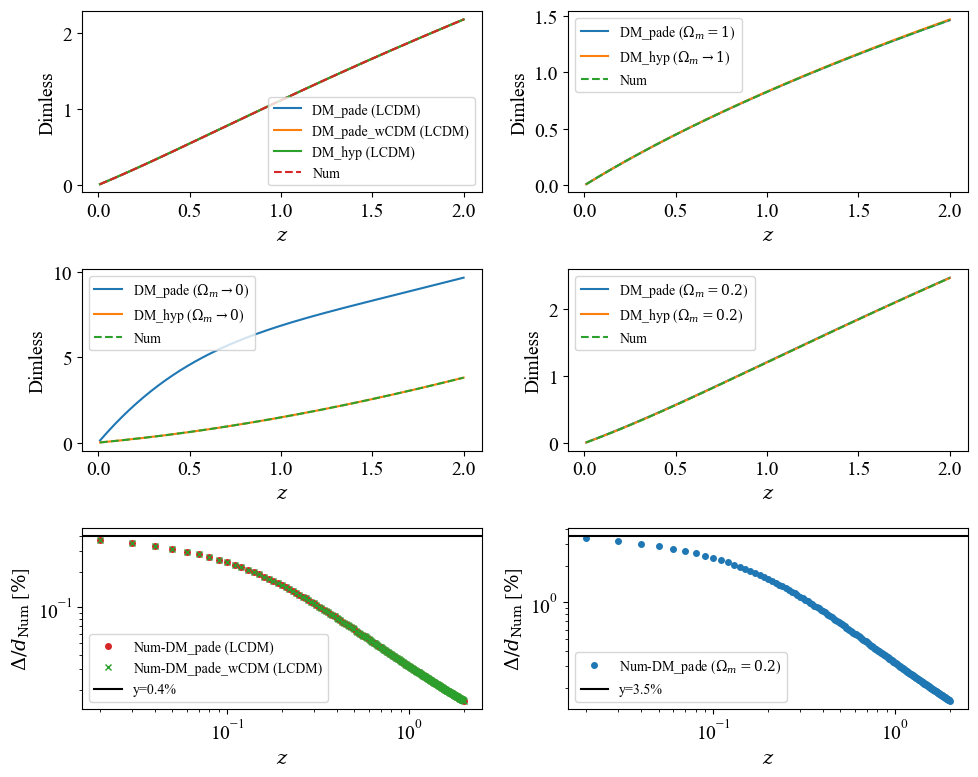

In [15]:
fig = plt.figure(figsize=(10,8))
ax1 = fig.add_subplot(3, 2, 1)
ax2 = fig.add_subplot(3, 2, 2)
ax3 = fig.add_subplot(3, 2, 3)
ax4 = fig.add_subplot(3, 2, 4)
ax5 = fig.add_subplot(3, 2, 5)
ax6 = fig.add_subplot(3, 2, 6)


ax1.plot(redshifts, DM_pade(redshifts, OMEGA_MATTER), label='DM_pade (LCDM)')
ax1.plot(redshifts, DM_pade_wCDM(redshifts, OMEGA_MATTER, w=-1), label='DM_pade_wCDM (LCDM)')
ax1.plot(redshifts, DM_distance_hyp(redshifts, OMEGA_MATTER), label='DM_hyp (LCDM)')
ax1.plot(redshifts, DM_LCDM_array, label='Num', ls='--')
ax1.set_xlabel(r'$z$')
ax1.set_ylabel(r'Dimless')
ax1.legend(fontsize=10)

ax2.plot(redshifts, DM_pade(redshifts, Om=1), label=r'DM_pade ($\Omega_m=1$)')
ax2.plot(redshifts, DM_distance_hyp(redshifts, Om=0.99), label=r'DM_hyp ($\Omega_m \rightarrow 1$)')
ax2.plot(redshifts, DM_MD_array, label='Num', ls='--')
ax2.set_xlabel(r'$z$')
ax2.set_ylabel(r'Dimless')
ax2.legend(fontsize=10)

ax3.plot(redshifts, DM_pade(redshifts, Om=0.01), label=r'DM_pade ($\Omega_m \rightarrow 0$)')
ax3.plot(redshifts, DM_distance_hyp(redshifts, Om=0.01), label=r'DM_hyp ($\Omega_m \rightarrow 0$)')
ax3.plot(redshifts, DM_LD_array, label='Num', ls='--')
ax3.set_xlabel(r'$z$')
ax3.set_ylabel(r'Dimless')
ax3.legend(fontsize=10)

ax4.plot(redshifts, DM_pade(redshifts, Om=0.2), label=r'DM_pade ($\Omega_m = 0.2$)')
ax4.plot(redshifts, DM_distance_hyp(redshifts, Om=0.2), label=r'DM_hyp ($\Omega_m = 0.2$)')
ax4.plot(redshifts, DM_lowOm_array, label='Num', ls='--')
ax4.set_xlabel(r'$z$')
ax4.set_ylabel(r'Dimless')
ax4.legend(fontsize=10)

ax5.plot(redshifts[1:], np.abs((DM_LCDM_array[1:]-DM_pade(redshifts[1:], OMEGA_MATTER)))/(DM_LCDM_array[1:])*100,\
         label='Num-DM_pade (LCDM)', c='tab:red', marker ='o', markersize=4, ls='')
ax5.plot(redshifts[1:], np.abs((DM_LCDM_array[1:]-DM_pade_wCDM(redshifts[1:], OMEGA_MATTER, -1)))/(DM_LCDM_array[1:])*100,\
         label='Num-DM_pade_wCDM (LCDM)', c='tab:green', marker ='x', markersize=4, ls='')
ax5.axhline(y=0.4, c='black', label='y=0.4%')
ax5.set_xlabel(r'$z$')
ax5.set_ylabel(r'$\Delta/d_{\rm Num}$ [$\%$]')
ax5.set_yscale('log')
ax5.set_xscale('log')
#ax2.set_ylim(10e-3, 0.3)
ax5.legend(fontsize=10)

ax6.plot(redshifts[1:], np.abs((DM_lowOm_array[1:]-DM_pade(redshifts[1:], Om=0.2)))/(DM_lowOm_array[1:])*100,\
         label=r'Num-DM_pade ($\Omega_m=0.2$)', c='tab:blue', marker ='o', markersize=4, ls='')
ax6.axhline(y=3.5, c='black', label='y=3.5%')
ax6.set_xlabel(r'$z$')
ax6.set_ylabel(r'$\Delta/d_{\rm Num}$ [$\%$]')
ax6.set_yscale('log')
ax6.set_xscale('log')
#ax2.set_ylim(10e-3, 0.3)
ax6.legend(fontsize=10)

plt.tight_layout()
plt.show()

2. $w$CDM

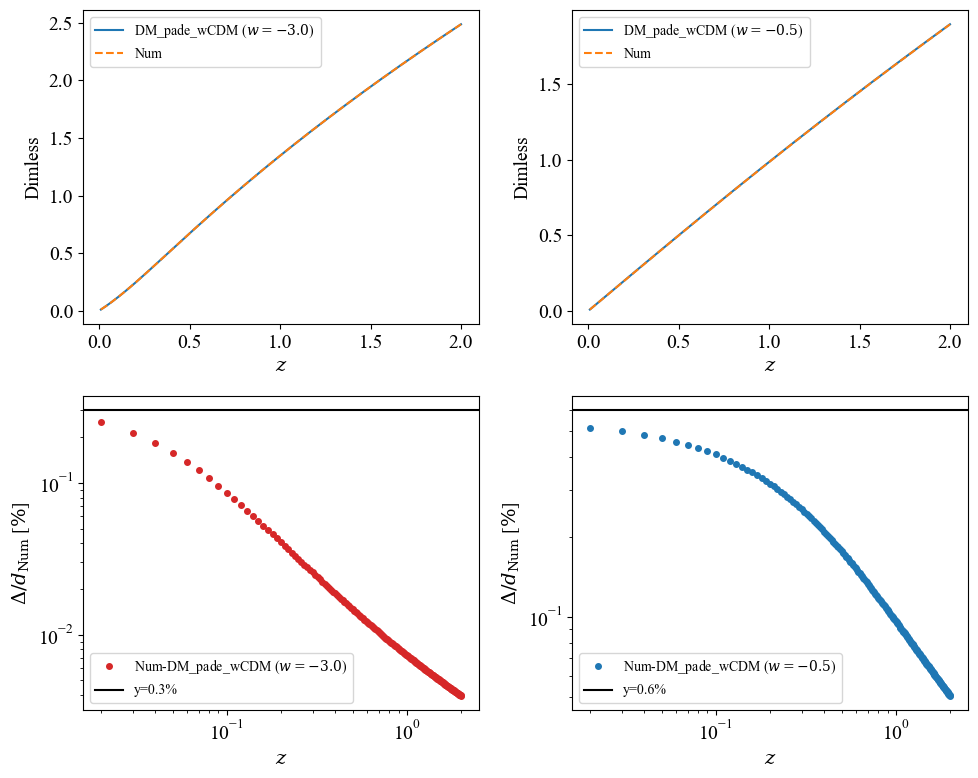

In [16]:
fig = plt.figure(figsize=(10,8))
ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2)
ax3 = fig.add_subplot(2, 2, 3)
ax4 = fig.add_subplot(2, 2, 4)


ax1.plot(redshifts, DM_pade_wCDM(redshifts, OMEGA_MATTER, w=-3.0), label=r'DM_pade_wCDM ($w=-3.0$)')
ax1.plot(redshifts, DM_wCDM30_array, label='Num', ls='--')
ax1.set_xlabel(r'$z$')
ax1.set_ylabel(r'Dimless')
ax1.legend(fontsize=10)

ax2.plot(redshifts, DM_pade_wCDM(redshifts, OMEGA_MATTER, w=-0.5), label=r'DM_pade_wCDM ($w=-0.5$)')
ax2.plot(redshifts, DM_wCDM05_array, label='Num', ls='--')
ax2.set_xlabel(r'$z$')
ax2.set_ylabel(r'Dimless')
ax2.legend(fontsize=10)

ax3.plot(redshifts[1:], np.abs((DM_wCDM30_array[1:]-DM_pade_wCDM(redshifts[1:], OMEGA_MATTER, w=-3.0)))/(DM_wCDM30_array[1:])*100,\
         label='Num-DM_pade_wCDM ($w=-3.0$)', c='tab:red', marker ='o', markersize=4, ls='')
ax3.axhline(y=0.3, c='black', label='y=0.3%')
ax3.set_xlabel(r'$z$')
ax3.set_ylabel(r'$\Delta/d_{\rm Num}$ [$\%$]')
ax3.set_yscale('log')
ax3.set_xscale('log')
#ax2.set_ylim(10e-3, 0.3)
ax3.legend(fontsize=10)

ax4.plot(redshifts[1:], np.abs((DM_wCDM05_array[1:]-DM_pade_wCDM(redshifts[1:], OMEGA_MATTER, w=-0.5)))/(DM_wCDM05_array[1:])*100,\
         label=r'Num-DM_pade_wCDM ($w=-0.5$)', c='tab:blue', marker ='o', markersize=4, ls='')
ax4.axhline(y=0.6, c='black', label='y=0.6%')
ax4.set_xlabel(r'$z$')
ax4.set_ylabel(r'$\Delta/d_{\rm Num}$ [$\%$]')
ax4.set_yscale('log')
ax4.set_xscale('log')
#ax2.set_ylim(10e-3, 0.3)
ax4.legend(fontsize=10)

plt.tight_layout()
plt.show()

---------------------------------------------

**Tables with Cosmological parameters and errors**

In [17]:
def rel_error_LCDM(z, Om):
    num = DM_distance(z, Om)
    pade = DM_pade(z, Om)

    DE = np.abs(num-pade)/num*100

    return DE

def rel_error_wCDM(z, Om, w):
    num = DM_distance_wCDM(z, Om, w)
    pade = DM_pade_wCDM(z, Om, w)

    DE = np.abs(num-pade)/num*100

    return DE    

In [18]:
z_table = np.array([0.01, 0.05, 0.1, 0.5, 1.0])
Om_table = np.array([0.2, 0.3, 0.4])
w_table = np.array([-3.0, -1.5, -1.0, -0.5])

In [19]:
for idx_Om, Om_val in enumerate(Om_table):
    print(f"For Om: {Om_val} we have:")
    for idx_z, z_val in enumerate(z_table):
        print(f"For z: {z_val}, we have DE: {round(rel_error_LCDM(z_val, Om_val), 2)}.")

    print("--------------------------------- \n")

For Om: 0.2 we have:
For z: 0.01, we have DE: 3.5.
For z: 0.05, we have DE: 2.89.
For z: 0.1, we have DE: 2.31.
For z: 0.5, we have DE: 0.68.
For z: 1.0, we have DE: 0.32.
--------------------------------- 

For Om: 0.3 we have:
For z: 0.01, we have DE: 0.47.
For z: 0.05, we have DE: 0.38.
For z: 0.1, we have DE: 0.29.
For z: 0.5, we have DE: 0.08.
For z: 1.0, we have DE: 0.04.
--------------------------------- 

For Om: 0.4 we have:
For z: 0.01, we have DE: 0.07.
For z: 0.05, we have DE: 0.05.
For z: 0.1, we have DE: 0.04.
For z: 0.5, we have DE: 0.01.
For z: 1.0, we have DE: 0.01.
--------------------------------- 



In [20]:
for idx_w, w_val in enumerate(w_table):
    print(f"For w: {w_val} we have:")
    for idx_Om, Om_val in enumerate(Om_table):
        print(f"For Om: {Om_val}, we have DE: {round(rel_error_wCDM(0.01, Om_val, w_val), 2)}.")

    print("--------------------------------- \n")

For w: -3.0 we have:
For Om: 0.2, we have DE: 2.62.
For Om: 0.3, we have DE: 0.36.
For Om: 0.4, we have DE: 0.05.
--------------------------------- 

For w: -1.5 we have:
For Om: 0.2, we have DE: 3.1.
For Om: 0.3, we have DE: 0.42.
For Om: 0.4, we have DE: 0.06.
--------------------------------- 

For w: -1.0 we have:
For Om: 0.2, we have DE: 3.5.
For Om: 0.3, we have DE: 0.47.
For Om: 0.4, we have DE: 0.07.
--------------------------------- 

For w: -0.5 we have:
For Om: 0.2, we have DE: 4.93.
For Om: 0.3, we have DE: 0.64.
For Om: 0.4, we have DE: 0.09.
--------------------------------- 



$\Lambda$CDM

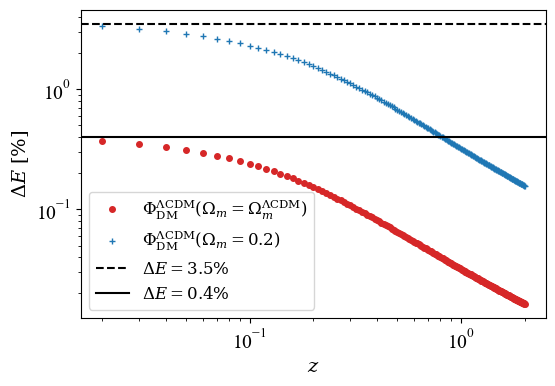

In [21]:
fig = plt.figure(figsize=(6, 4))
ax1 = fig.add_subplot(1, 1, 1)

ax1.plot(redshifts[1:], np.abs((DM_LCDM_array[1:]-DM_pade(redshifts[1:], OMEGA_MATTER)))/(DM_LCDM_array[1:])*100,\
         label=r'$\Phi_{\rm DM}^{\Lambda{\rm CDM}} (\Omega_m = \Omega_m^{\Lambda {\rm CDM}})$',\
         c='tab:red', marker ='o', markersize=4, ls='')
ax1.plot(redshifts[1:], np.abs((DM_lowOm_array[1:]-DM_pade(redshifts[1:], Om=0.2)))/(DM_lowOm_array[1:])*100,\
         label=r'$\Phi_{\rm DM}^{\Lambda{\rm CDM}} (\Omega_m = 0.2)$',\
         c='tab:blue', marker ='+', markersize=5, ls='')
ax1.axhline(y=3.5, c='black', label=r'$\Delta E = 3.5 \%$', ls='--')
ax1.axhline(y=0.4, c='black', label=r'$\Delta E = 0.4 \%$')
ax1.set_xlabel(r'$z$')
ax1.set_ylabel(r'$\Delta E \ [\%]$')
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.legend(fontsize=12)

if SAVE_FIG:
    plt.savefig("figures/DeltaE_PhiDM_LCDM.png", dpi=200, bbox_inches='tight')

plt.show()
plt.close()

$w$CDM

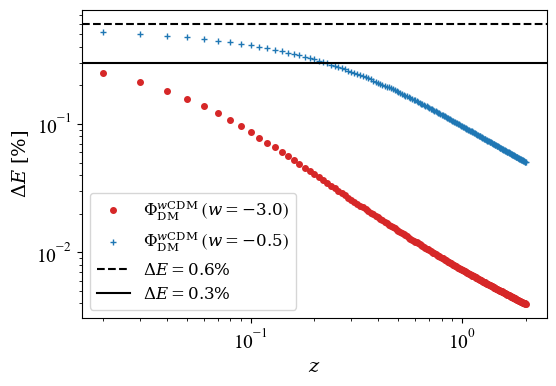

In [22]:
fig = plt.figure(figsize=(6, 4))
ax1 = fig.add_subplot(1, 1, 1)

ax1.plot(redshifts[1:], np.abs((DM_wCDM30_array[1:]-DM_pade_wCDM(redshifts[1:], OMEGA_MATTER, w=-3.0)))/(DM_wCDM30_array[1:])*100,\
         label=r'$\Phi_{\rm DM}^{w{\rm CDM}}$ ($w=-3.0$)', c='tab:red', marker ='o', markersize=4, ls='')
ax1.plot(redshifts[1:], np.abs((DM_wCDM05_array[1:]-DM_pade_wCDM(redshifts[1:], OMEGA_MATTER, w=-0.5)))/(DM_wCDM05_array[1:])*100,\
         label=r'$\Phi_{\rm DM}^{w{\rm CDM}}$ ($w=-0.5$)', c='tab:blue', marker ='+', markersize=5, ls='')
ax1.axhline(y=0.6, c='black', label=r'$\Delta E = 0.6 \%$', ls='--')
ax1.axhline(y=0.3, c='black', label=r'$\Delta E = 0.3 \%$')
ax1.set_xlabel(r'$z$')
ax1.set_ylabel(r'$\Delta E \ [\%]$')
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.legend(fontsize=12)

if SAVE_FIG:
    plt.savefig("figures/DeltaE_PhiDM_wCDM.png", dpi=200, bbox_inches='tight')

plt.show()
plt.close()

Create grid of $\Omega_m$ and $w$ for comparison with $w$CDM Pade approximation in ${\rm DM}$.

In [23]:
### We create a grid of values for Om and Ho
Omega_m_array = np.linspace(0.1, 1.0, 30)
w_array = np.linspace(-3.0, -0.5, 25)

Om_, w_ = np.meshgrid(Omega_m_array, w_array)

In [24]:
DM_num_wCDM_array = np.zeros_like(Om_)
DM_pade_wCDM_array = np.zeros_like(Om_)
z_star = redshifts[0]

for idx_Om, Om in enumerate(Omega_m_array):
    for idx_w, w_val in enumerate(w_array):
        DM_num_wCDM_array[idx_w, idx_Om] = DM_distance_wCDM(z_star, Om=Om, w=w_val)
        DM_pade_wCDM_array[idx_w, idx_Om] = DM_pade_wCDM(z_star, Om=Om, w=w_val)

In [25]:
rel_error_2D = np.abs(DM_num_wCDM_array-DM_pade_wCDM_array)/DM_num_wCDM_array*100

In [26]:
DE_LCDM = round(rel_error_wCDM(z_star, OMEGA_MATTER, w=-1), 4)

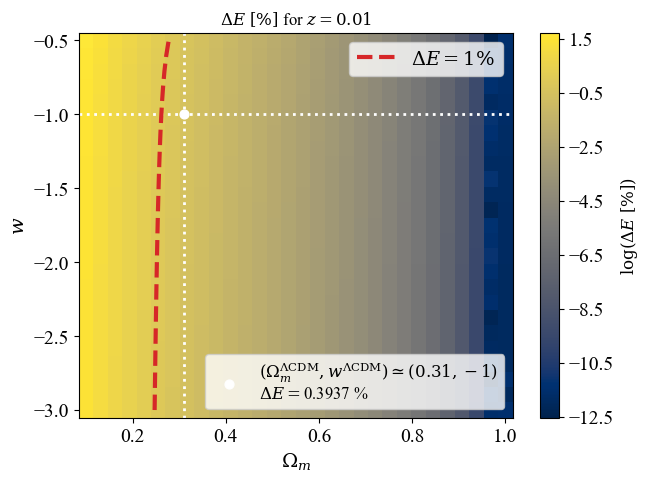

In [27]:
fig = plt.figure(figsize=(7, 5))
ax1 = fig.add_subplot(1, 1, 1)

pcm = ax1.pcolormesh(Om_, w_, np.log10(rel_error_2D), cmap='cividis')
l1 = ax1.contour(Om_, w_, np.log10(rel_error_2D), levels=[0], colors='tab:red', linewidths=3, linestyles='--')
cbar = fig.colorbar(pcm, ax=ax1)
cbar.set_ticks(np.arange(-12.5, 2, 2))
cbar.set_label(r'$\log(\Delta E \ [\%])$', size=12)

ax1.axhline(y=-1, c='white', lw=2, ls=':', zorder=1)
ax1.axvline(x=OMEGA_MATTER, c='white', lw=2, ls=':', zorder=1)
ax1.scatter(OMEGA_MATTER, -1, c='white', s=40, label=r'$(\Omega_m^{\Lambda {\rm CDM}}, w^{\Lambda {\rm CDM}}) \simeq (0.31, -1)$'+ '\n' rf'$\Delta E = ${DE_LCDM} %')

ax1.set_xlabel(r'$\Omega_m$')
ax1.set_ylabel(r'$w$')
ax1.set_title(r'$\Delta E \ [\%]$ for $z=0.01$', fontsize=12)

nm, _ = l1.legend_elements()
nm[0].set_linestyle(ls='--')

legend1 = ax1.legend(nm, [r'$\Delta E = 1 \%$'])
ax1.add_artist(legend1)

# hdl2, lab2 = l2.legend_elements()
ax1.legend(loc='lower right', fontsize=12)

if SAVE_FIG:
    plt.savefig("figures/DeltaE_PhiDM_wCDM_2D_plot.png", dpi=400, bbox_inches='tight')

plt.show()

__Approximant Timing estimates__

In [28]:
print("\n Timing for DL -- astropy --:")
%timeit (HUBBLE/(C_LIGHT/1e3))*cosmo_model.luminosity_distance(0.5).value

print("\n Timing for DL -- quad --:")
%timeit DL_distance(0.5, Om=OMEGA_MATTER)

print("\n Timing for DM -- quad --:")
%timeit  DM_distance(0.5, Om=OMEGA_MATTER)

########################################################################
print("\n ---------------------------------")
########################################################################

print("\n Timing for DM -- Hypergeometric --:")
%timeit  DM_distance_hyp(0.5, Om=OMEGA_MATTER)

########################################################################
print("\n ---------------------------------")
########################################################################

print("\n Timing for DL -- Pade --:")
%timeit dL_pade(0.5, Om=OMEGA_MATTER)

print("\n Timing for DM -- Pade --:")
%timeit  DM_pade(0.5, Om=OMEGA_MATTER)

########################################################################
print("\n ---------------------------------")
########################################################################

print("\n Timing for DM (wCDM) -- quad --:")
%timeit  DM_distance_wCDM(0.5, Om=OMEGA_MATTER, w=-1.2)

print("\n Timing for DM (wCDM) -- Pade --:")
%timeit  DM_pade_wCDM(0.5, Om=OMEGA_MATTER, w=-1.2)


 Timing for DL -- astropy --:
71.6 μs ± 5.43 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)

 Timing for DL -- quad --:
40.9 μs ± 3.4 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)

 Timing for DM -- quad --:
41.3 μs ± 4.3 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)

 ---------------------------------

 Timing for DM -- Hypergeometric --:
9.37 μs ± 559 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)

 ---------------------------------

 Timing for DL -- Pade --:
2.31 μs ± 402 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)

 Timing for DM -- Pade --:
2.42 μs ± 285 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)

 ---------------------------------

 Timing for DM (wCDM) -- quad --:
47.2 μs ± 3.47 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)

 Timing for DM (wCDM) -- Pade --:
19.7 μs ± 1.52 μs per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


## Summary

**For Luminosity Distance, $d_L$**

- Pade Approximant is about $\times 18$ faster.

- In terms of accuracy (for $0.01<z<2$):
    1) For $\Omega_m \sim 0.2$, error $< 2.0\%$.
    2) For $\Omega_m \geq 0.3$, error $< 0.3\%$.


**For Dispersion Measure, ${\rm DM}$**

- Pade Approximant is about $\times 17$ faster to the numerical integration ($\Lambda$CDM).

- Pade Approximant is about $\times 2.5$ faster to the numerical integration ($w$CDM).

- Pade Approximant is about $\times 2.5$ faster to the hypergeometric function.

- In terms of accuracy (for $0.01<z<2$):
    1) For $\Omega_m \sim 0.2$, error $< 3.5\%$.
    2) For $\Omega_m \geq 0.3$, error $< 0.4\%$.
        
---------------------------------------------------

- For sampling $\Omega_m \rightarrow 0$ the errors become quite large, and the Pade approximants are not applicable. 

--------------------------------------------------------------

# Appendix - Distance Approximants details

Here we calculate the Pade approximants for the luminosity distance $d_L$ and the dispersion measure ${\rm DM}$, following [[1111.6396](https://arxiv.org/abs/1111.6396)]. For more details, see [Bender & Orszag, Chapter 8.3].

The main steps are the following:

1. Change of variables $z \rightarrow a=1/(1+z)$. So for large $z$, $a$ will go to zero.
2. For $a \rightarrow 0$, we expand the integrand as a power series.
3. We integrate the power series, so we have a polynomial that we truncate to a desired value of $\mathcal{O}(a^n)$ (since $a$ is small).
4. We approximate this power series with a *Pade Approximant*.

In [29]:
from sympy import *
from scipy.interpolate import pade

## - Flat, $\Lambda$CDM models

In [30]:
## These are the already transformed variables

x, a, om = symbols('x a \Omega_m')

### Luminosity distance $dL$

- Step 1: Change of variables and specify the integrand

In [31]:
# Defining the helpful function
Fa = integrate(sqrt(om)/sqrt(om*x+(1-om)*x**4), (x, 0, a))
Fa

sqrt(\Omega_m)*Integral(1/sqrt(-\Omega_m*x**4 + \Omega_m*x + x**4), (x, 0, a))

- Steps 2 & 3: Expand the integrand to a power series and integrate

In [32]:
Fa_series = Fa.series(a, 0, 20)
Fa_series

2*sqrt(a) + a**(7/2)*(1/7 - 1/(7*\Omega_m)) + a**(13/2)*(3/52 - 3/(26*\Omega_m) + 3/(52*\Omega_m**2)) + a**(19/2)*(5/152 - 15/(152*\Omega_m) + 15/(152*\Omega_m**2) - 5/(152*\Omega_m**3)) + a**(25/2)*(7/320 - 7/(80*\Omega_m) + 21/(160*\Omega_m**2) - 7/(80*\Omega_m**3) + 7/(320*\Omega_m**4)) + a**(31/2)*(63/3968 - 315/(3968*\Omega_m) + 315/(1984*\Omega_m**2) - 315/(1984*\Omega_m**3) + 315/(3968*\Omega_m**4) - 63/(3968*\Omega_m**5)) + a**(37/2)*(231/18944 - 693/(9472*\Omega_m) + 3465/(18944*\Omega_m**2) - 1155/(4736*\Omega_m**3) + 3465/(18944*\Omega_m**4) - 693/(9472*\Omega_m**5) + 231/(18944*\Omega_m**6)) + O(a**20)

Making the powers clearer, by factorising $\sqrt{a}$.

In [33]:
Fa_series = expand(Fa_series/sqrt(a))
Fa_series

231*a**18/(18944*\Omega_m**6) - 63*a**15/(3968*\Omega_m**5) - 693*a**18/(9472*\Omega_m**5) + 7*a**12/(320*\Omega_m**4) + 315*a**15/(3968*\Omega_m**4) + 3465*a**18/(18944*\Omega_m**4) - 5*a**9/(152*\Omega_m**3) - 7*a**12/(80*\Omega_m**3) - 315*a**15/(1984*\Omega_m**3) - 1155*a**18/(4736*\Omega_m**3) + 3*a**6/(52*\Omega_m**2) + 15*a**9/(152*\Omega_m**2) + 21*a**12/(160*\Omega_m**2) + 315*a**15/(1984*\Omega_m**2) + 3465*a**18/(18944*\Omega_m**2) - a**3/(7*\Omega_m) - 3*a**6/(26*\Omega_m) - 15*a**9/(152*\Omega_m) - 7*a**12/(80*\Omega_m) - 315*a**15/(3968*\Omega_m) - 693*a**18/(9472*\Omega_m) + 2 + a**3/7 + 3*a**6/52 + 5*a**9/152 + 7*a**12/320 + 63*a**15/3968 + 231*a**18/18944 + O(a**(39/2))

Collecting all the powers of $a$ together.

In [34]:
Fa_series = collect(Fa_series, a).removeO()
Fa_series

a**18*(231/18944 - 693/(9472*\Omega_m) + 3465/(18944*\Omega_m**2) - 1155/(4736*\Omega_m**3) + 3465/(18944*\Omega_m**4) - 693/(9472*\Omega_m**5) + 231/(18944*\Omega_m**6)) + a**15*(63/3968 - 315/(3968*\Omega_m) + 315/(1984*\Omega_m**2) - 315/(1984*\Omega_m**3) + 315/(3968*\Omega_m**4) - 63/(3968*\Omega_m**5)) + a**12*(7/320 - 7/(80*\Omega_m) + 21/(160*\Omega_m**2) - 7/(80*\Omega_m**3) + 7/(320*\Omega_m**4)) + a**9*(5/152 - 15/(152*\Omega_m) + 15/(152*\Omega_m**2) - 5/(152*\Omega_m**3)) + a**6*(3/52 - 3/(26*\Omega_m) + 3/(52*\Omega_m**2)) + a**3*(1/7 - 1/(7*\Omega_m)) + 2

Substitute everywhere $x = (1-\Omega_m)/\Omega_m \times a^3$.

In [35]:
Fx_series = Fa_series.subs(a, (om/(1-om)*x)**(1/3)).removeO()
Fx_series

(\Omega_m*x/(1 - \Omega_m))**1.0*(1/7 - 1/(7*\Omega_m)) + (\Omega_m*x/(1 - \Omega_m))**2.0*(3/52 - 3/(26*\Omega_m) + 3/(52*\Omega_m**2)) + (\Omega_m*x/(1 - \Omega_m))**3.0*(5/152 - 15/(152*\Omega_m) + 15/(152*\Omega_m**2) - 5/(152*\Omega_m**3)) + (\Omega_m*x/(1 - \Omega_m))**4.0*(7/320 - 7/(80*\Omega_m) + 21/(160*\Omega_m**2) - 7/(80*\Omega_m**3) + 7/(320*\Omega_m**4)) + (\Omega_m*x/(1 - \Omega_m))**5.0*(63/3968 - 315/(3968*\Omega_m) + 315/(1984*\Omega_m**2) - 315/(1984*\Omega_m**3) + 315/(3968*\Omega_m**4) - 63/(3968*\Omega_m**5)) + (\Omega_m*x/(1 - \Omega_m))**6.0*(231/18944 - 693/(9472*\Omega_m) + 3465/(18944*\Omega_m**2) - 1155/(4736*\Omega_m**3) + 3465/(18944*\Omega_m**4) - 693/(9472*\Omega_m**5) + 231/(18944*\Omega_m**6)) + 2

In [36]:
collect(simplify(Fx_series), x)

(10153794560*\Omega_m**6 + 725271040*\Omega_m**5*(-\Omega_m*x/(\Omega_m - 1))**1.0*(\Omega_m - 1) + 292897920*\Omega_m**4*(-\Omega_m*x/(\Omega_m - 1))**2.0*(\Omega_m**2 - 2*\Omega_m + 1) + 167003200*\Omega_m**3*(-\Omega_m*x/(\Omega_m - 1))**3.0*(\Omega_m**3 - 3*\Omega_m**2 + 3*\Omega_m - 1) + 111057128*\Omega_m**2*(-\Omega_m*x/(\Omega_m - 1))**4.0*(\Omega_m**4 - 4*\Omega_m**3 + 6*\Omega_m**2 - 4*\Omega_m + 1) + 80605980*\Omega_m*(-\Omega_m*x/(\Omega_m - 1))**5.0*(\Omega_m**5 - 5*\Omega_m**4 + 10*\Omega_m**3 - 10*\Omega_m**2 + 5*\Omega_m - 1) + 61906845*(-\Omega_m*x/(\Omega_m - 1))**6.0*(\Omega_m**6 - 6*\Omega_m**5 + 15*\Omega_m**4 - 20*\Omega_m**3 + 15*\Omega_m**2 - 6*\Omega_m + 1))/(5076897280*\Omega_m**6)

In [37]:
# Cross-check the cancellations

expand((om-1)**6)

\Omega_m**6 - 6*\Omega_m**5 + 15*\Omega_m**4 - 20*\Omega_m**3 + 15*\Omega_m**2 - 6*\Omega_m + 1

In [38]:
expand((om-1)**5)

\Omega_m**5 - 5*\Omega_m**4 + 10*\Omega_m**3 - 10*\Omega_m**2 + 5*\Omega_m - 1

In [39]:
expand((om-1)**4)

\Omega_m**4 - 4*\Omega_m**3 + 6*\Omega_m**2 - 4*\Omega_m + 1

In [40]:
expand((om-1)**3)

\Omega_m**3 - 3*\Omega_m**2 + 3*\Omega_m - 1

In [41]:
# Let's find the coefficients

print("Coefficient of x^0:", 10153794560/5076897280)
print("Coefficient of x^1:", 725271040/5076897280)
print("Coefficient of x^2:", 292897920/5076897280)
print("Coefficient of x^3:", 167003200/5076897280)
print("Coefficient of x^4:", 111057128/5076897280)
print("Coefficient of x^5:", 80605980/5076897280)
print("Coefficient of x^6:", 61906845/5076897280)

Coefficient of x^0: 2.0
Coefficient of x^1: 0.14285714285714285
Coefficient of x^2: 0.057692307692307696
Coefficient of x^3: 0.03289473684210526
Coefficient of x^4: 0.021875
Coefficient of x^5: 0.015877016129032258
Coefficient of x^6: 0.012193834459459459


- Step 4: Turn the power series to a Pade Approximant

In [42]:
## Power series coefficients
F_exp=[2.0, -0.14285714285714285, 0.057692307692307696, -0.03289473684210526, 0.021875, -0.015877016129032258, 0.012193834459459459]

## Calculate Pade
p, q = pade(F_exp, 3, 3)

In [43]:
## Numerator coefficients
p

poly1d([0.05312495, 0.8830444 , 2.64086441, 2.        ])

In [44]:
## Denominator coefficients
q

poly1d([0.03943821, 0.51209467, 1.39186078, 1.        ])

### Dispersion Measure ${\rm DM}$

- Step 1: Change of variables and specify the integrand

In [45]:
# Defining the helpful function
Fa = integrate(sqrt(om)/sqrt(om*x**3+(1-om)*x**6), x)
Fa

sqrt(\Omega_m)*Integral(1/sqrt(-\Omega_m*x**6 + \Omega_m*x**3 + x**6), x)

- Steps 2 & 3: Expand the integrand to a power series and integrate

In [46]:
Fa_series = Fa.series(x, 0, 20)
Fa_series

-2/sqrt(x) + x**(5/2)*(1/5 - 1/(5*\Omega_m)) + 3*x**(11/2)*(-1 + 1/\Omega_m)**2/44 - 5*x**(17/2)*(-1 + 1/\Omega_m)**3/136 + 35*x**(23/2)*(-1 + 1/\Omega_m)**4/1472 - 63*x**(29/2)*(-1 + 1/\Omega_m)**5/3712 + 33*x**(35/2)*(-1 + 1/\Omega_m)**6/2560 + O(x**20)

In [47]:
Fa_series = Fa_series.subs(x, a)
Fa_series

-2/sqrt(a) + a**(5/2)*(1/5 - 1/(5*\Omega_m)) + 3*a**(11/2)*(-1 + 1/\Omega_m)**2/44 - 5*a**(17/2)*(-1 + 1/\Omega_m)**3/136 + 35*a**(23/2)*(-1 + 1/\Omega_m)**4/1472 - 63*a**(29/2)*(-1 + 1/\Omega_m)**5/3712 + 33*a**(35/2)*(-1 + 1/\Omega_m)**6/2560 + O(a**20)

Making the powers clearer, by factorising $1/\sqrt{a}$.

In [48]:
Fa_series = expand(Fa_series*sqrt(a))
Fa_series

33*a**18/(2560*\Omega_m**6) - 63*a**15/(3712*\Omega_m**5) - 99*a**18/(1280*\Omega_m**5) + 35*a**12/(1472*\Omega_m**4) + 315*a**15/(3712*\Omega_m**4) + 99*a**18/(512*\Omega_m**4) - 5*a**9/(136*\Omega_m**3) - 35*a**12/(368*\Omega_m**3) - 315*a**15/(1856*\Omega_m**3) - 33*a**18/(128*\Omega_m**3) + 3*a**6/(44*\Omega_m**2) + 15*a**9/(136*\Omega_m**2) + 105*a**12/(736*\Omega_m**2) + 315*a**15/(1856*\Omega_m**2) + 99*a**18/(512*\Omega_m**2) - a**3/(5*\Omega_m) - 3*a**6/(22*\Omega_m) - 15*a**9/(136*\Omega_m) - 35*a**12/(368*\Omega_m) - 315*a**15/(3712*\Omega_m) - 99*a**18/(1280*\Omega_m) - 2 + a**3/5 + 3*a**6/44 + 5*a**9/136 + 35*a**12/1472 + 63*a**15/3712 + 33*a**18/2560 + O(a**(41/2))

Collecting all the powers of $a$ together.

In [49]:
Fa_series = collect(Fa_series, a).removeO()
Fa_series

a**18*(33/2560 - 99/(1280*\Omega_m) + 99/(512*\Omega_m**2) - 33/(128*\Omega_m**3) + 99/(512*\Omega_m**4) - 99/(1280*\Omega_m**5) + 33/(2560*\Omega_m**6)) + a**15*(63/3712 - 315/(3712*\Omega_m) + 315/(1856*\Omega_m**2) - 315/(1856*\Omega_m**3) + 315/(3712*\Omega_m**4) - 63/(3712*\Omega_m**5)) + a**12*(35/1472 - 35/(368*\Omega_m) + 105/(736*\Omega_m**2) - 35/(368*\Omega_m**3) + 35/(1472*\Omega_m**4)) + a**9*(5/136 - 15/(136*\Omega_m) + 15/(136*\Omega_m**2) - 5/(136*\Omega_m**3)) + a**6*(3/44 - 3/(22*\Omega_m) + 3/(44*\Omega_m**2)) + a**3*(1/5 - 1/(5*\Omega_m)) - 2

In [50]:
## Intuition of how to define your $x$ parameter
simplify(Fa_series.coeff(a**3))

(\Omega_m - 1)/(5*\Omega_m)

Substitute everywhere $x = (1-\Omega_m)/\Omega_m \times a^3$.

In [51]:
Fx_series = Fa_series.subs(a, (om/(1-om)*x)**(1/3)).removeO()
Fx_series

(\Omega_m*x/(1 - \Omega_m))**1.0*(1/5 - 1/(5*\Omega_m)) + (\Omega_m*x/(1 - \Omega_m))**2.0*(3/44 - 3/(22*\Omega_m) + 3/(44*\Omega_m**2)) + (\Omega_m*x/(1 - \Omega_m))**3.0*(5/136 - 15/(136*\Omega_m) + 15/(136*\Omega_m**2) - 5/(136*\Omega_m**3)) + (\Omega_m*x/(1 - \Omega_m))**4.0*(35/1472 - 35/(368*\Omega_m) + 105/(736*\Omega_m**2) - 35/(368*\Omega_m**3) + 35/(1472*\Omega_m**4)) + (\Omega_m*x/(1 - \Omega_m))**5.0*(63/3712 - 315/(3712*\Omega_m) + 315/(1856*\Omega_m**2) - 315/(1856*\Omega_m**3) + 315/(3712*\Omega_m**4) - 63/(3712*\Omega_m**5)) + (\Omega_m*x/(1 - \Omega_m))**6.0*(33/2560 - 99/(1280*\Omega_m) + 99/(512*\Omega_m**2) - 33/(128*\Omega_m**3) + 99/(512*\Omega_m**4) - 99/(1280*\Omega_m**5) + 33/(2560*\Omega_m**6)) - 2

In [52]:
collect(simplify(Fx_series), x)

(-638612480*\Omega_m**6 + 63861248*\Omega_m**5*(-\Omega_m*x/(\Omega_m - 1))**1.0*(\Omega_m - 1) + 21770880*\Omega_m**4*(-\Omega_m*x/(\Omega_m - 1))**2.0*(\Omega_m**2 - 2*\Omega_m + 1) + 11739200*\Omega_m**3*(-\Omega_m*x/(\Omega_m - 1))**3.0*(\Omega_m**3 - 3*\Omega_m**2 + 3*\Omega_m - 1) + 7592200*\Omega_m**2*(-\Omega_m*x/(\Omega_m - 1))**4.0*(\Omega_m**4 - 4*\Omega_m**3 + 6*\Omega_m**2 - 4*\Omega_m + 1) + 5419260*\Omega_m*(-\Omega_m*x/(\Omega_m - 1))**5.0*(\Omega_m**5 - 5*\Omega_m**4 + 10*\Omega_m**3 - 10*\Omega_m**2 + 5*\Omega_m - 1) + 4116057*(-\Omega_m*x/(\Omega_m - 1))**6.0*(\Omega_m**6 - 6*\Omega_m**5 + 15*\Omega_m**4 - 20*\Omega_m**3 + 15*\Omega_m**2 - 6*\Omega_m + 1))/(319306240*\Omega_m**6)

In [53]:
print("Coefficient of x^0:", 638612480/319306240)
print("Coefficient of x^1:", 63861248/319306240)
print("Coefficient of x^2:", 21770880/319306240)
print("Coefficient of x^3:", 11739200/319306240)
print("Coefficient of x^4:", 7592200/319306240)
print("Coefficient of x^5:", 5419260/319306240)
print("Coefficient of x^6:", 4116057/319306240)

Coefficient of x^0: 2.0
Coefficient of x^1: 0.2
Coefficient of x^2: 0.06818181818181818
Coefficient of x^3: 0.03676470588235294
Coefficient of x^4: 0.02377717391304348
Coefficient of x^5: 0.01697198275862069
Coefficient of x^6: 0.012890625


In [54]:
F_exp=[-2.0, -0.2, 0.06818181818181818, -0.03676470588235294, 0.02377717391304348, -0.01697198275862069, 0.012890625]

p, q = pade(F_exp, 3, 3)

In [55]:
p

poly1d([-0.0913347 , -1.0945641 , -2.85592665, -2.        ])

In [56]:
q

poly1d([0.02769881, 0.44857662, 1.32796333, 1.        ])

---------------------------------------------------------

## - Curved, $\Lambda$CDM models

In [57]:
## These are the already transformed variables

x, a, om, ol = symbols('x a \Omega_m \Omega_\Lambda')

### Luminosity distance $dL$

- Step 1: Change of variables and specify the integrand

In [58]:
# Defining the helpful function
Fa = integrate(sqrt(om)/sqrt(om*x+ol*x**4+(1-om-ol)*x**2), (x, 0, a))
Fa

sqrt(\Omega_m)*Integral(1/sqrt(\Omega_\Lambda*x**4 - \Omega_\Lambda*x**2 - \Omega_m*x**2 + \Omega_m*x + x**2), (x, 0, a))

- Steps 2 & 3: Expand the integrand to a power series and integrate

In [59]:
Fa_series = Fa.series(a, 0, 3)
Fa_series

2*sqrt(a) + a**(3/2)*(\Omega_\Lambda/(3*\Omega_m) + 1/3 - 1/(3*\Omega_m)) + a**(5/2)*(3*\Omega_\Lambda**2/(20*\Omega_m**2) + 3*\Omega_\Lambda/(10*\Omega_m) - 3*\Omega_\Lambda/(10*\Omega_m**2) + 3/20 - 3/(10*\Omega_m) + 3/(20*\Omega_m**2)) + O(a**3)

Making the powers clearer, by factorising $\sqrt{a}$.

In [60]:
Fa_series = expand(Fa_series/sqrt(a))
Fa_series

3*a**2/(20*\Omega_m**2) - a/(3*\Omega_m) - 3*a**2/(10*\Omega_m) + 2 + a/3 + 3*a**2/20 - 3*\Omega_\Lambda*a**2/(10*\Omega_m**2) + \Omega_\Lambda*a/(3*\Omega_m) + 3*\Omega_\Lambda*a**2/(10*\Omega_m) + 3*\Omega_\Lambda**2*a**2/(20*\Omega_m**2) + O(a**(5/2))

Collecting all the powers of $a$ together.

In [61]:
Fa_series = collect(Fa_series, a).removeO()
Fa_series

a**2*(3*\Omega_\Lambda**2/(20*\Omega_m**2) + 3*\Omega_\Lambda/(10*\Omega_m) - 3*\Omega_\Lambda/(10*\Omega_m**2) + 3/20 - 3/(10*\Omega_m) + 3/(20*\Omega_m**2)) + a*(\Omega_\Lambda/(3*\Omega_m) + 1/3 - 1/(3*\Omega_m)) + 2

Substitute everywhere $x = (1-\Omega_m-\Omega_\Lambda)/\Omega_m \times a$.

In [62]:
Fx_series = Fa_series.subs(a, (om/(1-om-ol)*x)).removeO()
Fx_series

\Omega_m**2*x**2*(3*\Omega_\Lambda**2/(20*\Omega_m**2) + 3*\Omega_\Lambda/(10*\Omega_m) - 3*\Omega_\Lambda/(10*\Omega_m**2) + 3/20 - 3/(10*\Omega_m) + 3/(20*\Omega_m**2))/(-\Omega_\Lambda - \Omega_m + 1)**2 + \Omega_m*x*(\Omega_\Lambda/(3*\Omega_m) + 1/3 - 1/(3*\Omega_m))/(-\Omega_\Lambda - \Omega_m + 1) + 2

In [63]:
collect(simplify(Fx_series), x)

3*x**2/20 - x/3 + 2

- Step 4: Turn the power series to a Pade Approximant

In [64]:
## Power series coefficients
F_exp=[2.0, -1/3, 3/20]

## Calculate Pade
p, q = pade(F_exp, 1, 1)

In [65]:
## Numerator coefficients
p

poly1d([0.56666667, 2.        ])

In [66]:
## Denominator coefficients
q

poly1d([0.45, 1.  ])

### Dispersion Measure ${\rm DM}$

In [67]:
# Defining the helpful function
Fa = integrate(sqrt(om)/sqrt(om*x**3+ol*x**6+(1-om-ol)*x**4), x)
Fa

sqrt(\Omega_m)*Integral(1/sqrt(\Omega_\Lambda*x**6 - \Omega_\Lambda*x**4 - \Omega_m*x**4 + \Omega_m*x**3 + x**4), x)

- Steps 2 & 3: Expand the integrand to a power series and integrate

In [68]:
Fa_series = Fa.series(x, 0, 2)
Fa_series

-2/sqrt(x) + sqrt(x)*(\Omega_\Lambda/\Omega_m + 1 - 1/\Omega_m) + x**(3/2)*(-\Omega_\Lambda/\Omega_m - 1 + 1/\Omega_m)**2/4 + O(x**2)

In [69]:
Fa_series = Fa_series.subs(x, a)
Fa_series

-2/sqrt(a) + sqrt(a)*(\Omega_\Lambda/\Omega_m + 1 - 1/\Omega_m) + a**(3/2)*(-\Omega_\Lambda/\Omega_m - 1 + 1/\Omega_m)**2/4 + O(a**2)

Making the powers clearer, by factorising $1/\sqrt{a}$.

In [70]:
Fa_series = expand(Fa_series*sqrt(a))
Fa_series

a**2/(4*\Omega_m**2) - a/\Omega_m - a**2/(2*\Omega_m) - 2 + a + a**2/4 - \Omega_\Lambda*a**2/(2*\Omega_m**2) + \Omega_\Lambda*a/\Omega_m + \Omega_\Lambda*a**2/(2*\Omega_m) + \Omega_\Lambda**2*a**2/(4*\Omega_m**2) + O(a**(5/2))

Collecting all the powers of $a$ together.

In [71]:
Fa_series = collect(Fa_series, a).removeO()
Fa_series

a**2*(\Omega_\Lambda**2/(4*\Omega_m**2) + \Omega_\Lambda/(2*\Omega_m) - \Omega_\Lambda/(2*\Omega_m**2) + 1/4 - 1/(2*\Omega_m) + 1/(4*\Omega_m**2)) + a*(\Omega_\Lambda/\Omega_m + 1 - 1/\Omega_m) - 2

In [72]:
simplify(Fa_series.coeff(a**1))

(\Omega_\Lambda + \Omega_m - 1)/\Omega_m

Substitute everywhere $x = (1-\Omega_m-\Omega_\Lambda)/\Omega_m \times a$.

In [73]:
Fx_series = Fa_series.subs(a, (om/(1-om-ol)*x)).removeO()
Fx_series

\Omega_m**2*x**2*(\Omega_\Lambda**2/(4*\Omega_m**2) + \Omega_\Lambda/(2*\Omega_m) - \Omega_\Lambda/(2*\Omega_m**2) + 1/4 - 1/(2*\Omega_m) + 1/(4*\Omega_m**2))/(-\Omega_\Lambda - \Omega_m + 1)**2 + \Omega_m*x*(\Omega_\Lambda/\Omega_m + 1 - 1/\Omega_m)/(-\Omega_\Lambda - \Omega_m + 1) - 2

In [74]:
collect(simplify(Fx_series), x)

x**2/4 - x - 2

In [75]:
F_exp=[-2.0, -1.0, 1/4]

p, q = pade(F_exp, 1, 1)

In [76]:
p

poly1d([-1.5, -2. ])

In [77]:
q

poly1d([0.25, 1.  ])

------------------------------------------------------

## - $w$CDM models

In [78]:
## These are the already transformed variables

x, a, s = symbols('x a s')
w = Symbol('w', negative=True)

### Dispersion Measure ${\rm DM}$

In [79]:
s_factor = (s/x)**(-1/(6*w))
s_factor

(s/x)**(-1/(6*w))

In [80]:
integrand_x = (1/x)*1/sqrt(1+x)
integrand_x

1/(x*sqrt(x + 1))

In [81]:
Series_int_x = (integrand_x.series(x, 0, 6)).removeO()
Series_int_x

231*x**5/1024 - 63*x**4/256 + 35*x**3/128 - 5*x**2/16 + 3*x/8 - 1/2 + 1/x

In [82]:
integrand_all = s_factor*Series_int_x
integrand_all

(231*x**5/1024 - 63*x**4/256 + 35*x**3/128 - 5*x**2/16 + 3*x/8 - 1/2 + 1/x)/(s/x)**(1/(6*w))

In [83]:
integral_all = integrate(integrand_all, x)
integral_all

Piecewise((s*(231*x**5/5120 - 63*x**4/1024 + 35*x**3/384 - 5*x**2/32 + 3*x/8 - log(x)/2 - 1/x), Eq(w, -1/6)), (s**2*(231*x**4/4096 - 21*x**3/256 + 35*x**2/256 - 5*x/16 + 3*log(x)/8 + 1/(2*x) - 1/(2*x**2)), Eq(w, -1/12)), (s**3*(77*x**3/1024 - 63*x**2/512 + 35*x/128 - 5*log(x)/16 - 3/(8*x) + 1/(4*x**2) - 1/(3*x**3)), Eq(w, -1/18)), (s**4*(231*x**2/2048 - 63*x/256 + 35*log(x)/128 + 5/(16*x) - 3/(16*x**2) + 1/(6*x**3) - 1/(4*x**4)), Eq(w, -1/24)), (s**5*(231*x/1024 - 63*log(x)/256 - 35/(128*x) + 5/(32*x**2) - 1/(8*x**3) + 1/(8*x**4) - 1/(5*x**5)), Eq(w, -1/30)), (s**6*(231*log(x)/1024 + 63/(256*x) - 35/(256*x**2) + 5/(48*x**3) - 3/(32*x**4) + 1/(10*x**5) - 1/(6*x**6)), Eq(w, -1/36)), (103195607040*w**7/((s/x)**(1/(6*w))*(17199267840*w**6 + 7023034368*w**5 + 1077608448*w**4 + 81285120*w**3 + 3225600*w**2 + 64512*w + 512)) + 646652160*w**6*x**6/((s/x)**(1/(6*w))*(17199267840*w**6 + 7023034368*w**5 + 1077608448*w**4 + 81285120*w**3 + 3225600*w**2 + 64512*w + 512)) - 846526464*w**6*x**5/((s/x

In [84]:
integral_all = integral_all.args[-1][0]
integral_all

103195607040*w**7/((s/x)**(1/(6*w))*(17199267840*w**6 + 7023034368*w**5 + 1077608448*w**4 + 81285120*w**3 + 3225600*w**2 + 64512*w + 512)) + 646652160*w**6*x**6/((s/x)**(1/(6*w))*(17199267840*w**6 + 7023034368*w**5 + 1077608448*w**4 + 81285120*w**3 + 3225600*w**2 + 64512*w + 512)) - 846526464*w**6*x**5/((s/x)**(1/(6*w))*(17199267840*w**6 + 7023034368*w**5 + 1077608448*w**4 + 81285120*w**3 + 3225600*w**2 + 64512*w + 512)) + 1175731200*w**6*x**4/((s/x)**(1/(6*w))*(17199267840*w**6 + 7023034368*w**5 + 1077608448*w**4 + 81285120*w**3 + 3225600*w**2 + 64512*w + 512)) - 1791590400*w**6*x**3/((s/x)**(1/(6*w))*(17199267840*w**6 + 7023034368*w**5 + 1077608448*w**4 + 81285120*w**3 + 3225600*w**2 + 64512*w + 512)) + 3224862720*w**6*x**2/((s/x)**(1/(6*w))*(17199267840*w**6 + 7023034368*w**5 + 1077608448*w**4 + 81285120*w**3 + 3225600*w**2 + 64512*w + 512)) - 8599633920*w**6*x/((s/x)**(1/(6*w))*(17199267840*w**6 + 7023034368*w**5 + 1077608448*w**4 + 81285120*w**3 + 3225600*w**2 + 64512*w + 512)) + 

In [85]:
simple_integral = simplify(integral_all/s_factor)
simple_integral

3*w*(34398535680*w**6 + 215550720*w**5*x**6 - 282175488*w**5*x**5 + 391910400*w**5*x**4 - 597196800*w**5*x**3 + 1074954240*w**5*x**2 - 2866544640*w**5*x + 14046068736*w**5 + 82029024*w**4*x**6 - 105815808*w**4*x**5 + 143700480*w**4*x**4 - 210677760*w**4*x**3 + 349360128*w**4*x**2 - 692748288*w**4*x + 2155216896*w**4 + 11226600*w**3*x**6 - 14152320*w**3*x**5 + 18567360*w**3*x**4 - 25712640*w**3*x**3 + 38237184*w**3*x**2 - 64143360*w**3*x + 162570240*w**3 + 706860*w**2*x**6 - 861840*w**2*x**5 + 1078560*w**2*x**4 - 1393920*w**2*x**3 + 1893888*w**2*x**2 - 2856960*w**2*x + 6451200*w**2 + 20790*w*x**6 - 24192*w*x**5 + 28560*w*x**4 - 34560*w*x**3 + 43776*w*x**2 - 61440*w*x + 129024*w + 231*x**6 - 252*x**5 + 280*x**4 - 320*x**3 + 384*x**2 - 512*x + 1024)/(512*(33592320*w**6 + 13716864*w**5 + 2104704*w**4 + 158760*w**3 + 6300*w**2 + 126*w + 1))

In [86]:
Fx_series = collect(expand(simple_integral), x)
Fx_series

103195607040*w**7/(17199267840*w**6 + 7023034368*w**5 + 1077608448*w**4 + 81285120*w**3 + 3225600*w**2 + 64512*w + 512) + 42138206208*w**6/(17199267840*w**6 + 7023034368*w**5 + 1077608448*w**4 + 81285120*w**3 + 3225600*w**2 + 64512*w + 512) + 6465650688*w**5/(17199267840*w**6 + 7023034368*w**5 + 1077608448*w**4 + 81285120*w**3 + 3225600*w**2 + 64512*w + 512) + 487710720*w**4/(17199267840*w**6 + 7023034368*w**5 + 1077608448*w**4 + 81285120*w**3 + 3225600*w**2 + 64512*w + 512) + 19353600*w**3/(17199267840*w**6 + 7023034368*w**5 + 1077608448*w**4 + 81285120*w**3 + 3225600*w**2 + 64512*w + 512) + 387072*w**2/(17199267840*w**6 + 7023034368*w**5 + 1077608448*w**4 + 81285120*w**3 + 3225600*w**2 + 64512*w + 512) + 3072*w/(17199267840*w**6 + 7023034368*w**5 + 1077608448*w**4 + 81285120*w**3 + 3225600*w**2 + 64512*w + 512) + x**6*(646652160*w**6/(17199267840*w**6 + 7023034368*w**5 + 1077608448*w**4 + 81285120*w**3 + 3225600*w**2 + 64512*w + 512) + 246087072*w**5/(17199267840*w**6 + 7023034368*w*

In [87]:
a0 = Fx_series.subs(x, 0)
a0

103195607040*w**7/(17199267840*w**6 + 7023034368*w**5 + 1077608448*w**4 + 81285120*w**3 + 3225600*w**2 + 64512*w + 512) + 42138206208*w**6/(17199267840*w**6 + 7023034368*w**5 + 1077608448*w**4 + 81285120*w**3 + 3225600*w**2 + 64512*w + 512) + 6465650688*w**5/(17199267840*w**6 + 7023034368*w**5 + 1077608448*w**4 + 81285120*w**3 + 3225600*w**2 + 64512*w + 512) + 487710720*w**4/(17199267840*w**6 + 7023034368*w**5 + 1077608448*w**4 + 81285120*w**3 + 3225600*w**2 + 64512*w + 512) + 19353600*w**3/(17199267840*w**6 + 7023034368*w**5 + 1077608448*w**4 + 81285120*w**3 + 3225600*w**2 + 64512*w + 512) + 387072*w**2/(17199267840*w**6 + 7023034368*w**5 + 1077608448*w**4 + 81285120*w**3 + 3225600*w**2 + 64512*w + 512) + 3072*w/(17199267840*w**6 + 7023034368*w**5 + 1077608448*w**4 + 81285120*w**3 + 3225600*w**2 + 64512*w + 512)

In [88]:
a1 = Fx_series.coeff(x**1)
a1

-8599633920*w**6/(17199267840*w**6 + 7023034368*w**5 + 1077608448*w**4 + 81285120*w**3 + 3225600*w**2 + 64512*w + 512) - 2078244864*w**5/(17199267840*w**6 + 7023034368*w**5 + 1077608448*w**4 + 81285120*w**3 + 3225600*w**2 + 64512*w + 512) - 192430080*w**4/(17199267840*w**6 + 7023034368*w**5 + 1077608448*w**4 + 81285120*w**3 + 3225600*w**2 + 64512*w + 512) - 8570880*w**3/(17199267840*w**6 + 7023034368*w**5 + 1077608448*w**4 + 81285120*w**3 + 3225600*w**2 + 64512*w + 512) - 184320*w**2/(17199267840*w**6 + 7023034368*w**5 + 1077608448*w**4 + 81285120*w**3 + 3225600*w**2 + 64512*w + 512) - 1536*w/(17199267840*w**6 + 7023034368*w**5 + 1077608448*w**4 + 81285120*w**3 + 3225600*w**2 + 64512*w + 512)

In [89]:
a2 = Fx_series.coeff(x**2)
a2

3224862720*w**6/(17199267840*w**6 + 7023034368*w**5 + 1077608448*w**4 + 81285120*w**3 + 3225600*w**2 + 64512*w + 512) + 1048080384*w**5/(17199267840*w**6 + 7023034368*w**5 + 1077608448*w**4 + 81285120*w**3 + 3225600*w**2 + 64512*w + 512) + 114711552*w**4/(17199267840*w**6 + 7023034368*w**5 + 1077608448*w**4 + 81285120*w**3 + 3225600*w**2 + 64512*w + 512) + 5681664*w**3/(17199267840*w**6 + 7023034368*w**5 + 1077608448*w**4 + 81285120*w**3 + 3225600*w**2 + 64512*w + 512) + 131328*w**2/(17199267840*w**6 + 7023034368*w**5 + 1077608448*w**4 + 81285120*w**3 + 3225600*w**2 + 64512*w + 512) + 1152*w/(17199267840*w**6 + 7023034368*w**5 + 1077608448*w**4 + 81285120*w**3 + 3225600*w**2 + 64512*w + 512)

In [90]:
a3 = Fx_series.coeff(x**3)
a3

-1791590400*w**6/(17199267840*w**6 + 7023034368*w**5 + 1077608448*w**4 + 81285120*w**3 + 3225600*w**2 + 64512*w + 512) - 632033280*w**5/(17199267840*w**6 + 7023034368*w**5 + 1077608448*w**4 + 81285120*w**3 + 3225600*w**2 + 64512*w + 512) - 77137920*w**4/(17199267840*w**6 + 7023034368*w**5 + 1077608448*w**4 + 81285120*w**3 + 3225600*w**2 + 64512*w + 512) - 4181760*w**3/(17199267840*w**6 + 7023034368*w**5 + 1077608448*w**4 + 81285120*w**3 + 3225600*w**2 + 64512*w + 512) - 103680*w**2/(17199267840*w**6 + 7023034368*w**5 + 1077608448*w**4 + 81285120*w**3 + 3225600*w**2 + 64512*w + 512) - 960*w/(17199267840*w**6 + 7023034368*w**5 + 1077608448*w**4 + 81285120*w**3 + 3225600*w**2 + 64512*w + 512)

In [91]:
a4 = Fx_series.coeff(x**4)
a4

1175731200*w**6/(17199267840*w**6 + 7023034368*w**5 + 1077608448*w**4 + 81285120*w**3 + 3225600*w**2 + 64512*w + 512) + 431101440*w**5/(17199267840*w**6 + 7023034368*w**5 + 1077608448*w**4 + 81285120*w**3 + 3225600*w**2 + 64512*w + 512) + 55702080*w**4/(17199267840*w**6 + 7023034368*w**5 + 1077608448*w**4 + 81285120*w**3 + 3225600*w**2 + 64512*w + 512) + 3235680*w**3/(17199267840*w**6 + 7023034368*w**5 + 1077608448*w**4 + 81285120*w**3 + 3225600*w**2 + 64512*w + 512) + 85680*w**2/(17199267840*w**6 + 7023034368*w**5 + 1077608448*w**4 + 81285120*w**3 + 3225600*w**2 + 64512*w + 512) + 840*w/(17199267840*w**6 + 7023034368*w**5 + 1077608448*w**4 + 81285120*w**3 + 3225600*w**2 + 64512*w + 512)

In [92]:
a5 = Fx_series.coeff(x**5)
a5

-846526464*w**6/(17199267840*w**6 + 7023034368*w**5 + 1077608448*w**4 + 81285120*w**3 + 3225600*w**2 + 64512*w + 512) - 317447424*w**5/(17199267840*w**6 + 7023034368*w**5 + 1077608448*w**4 + 81285120*w**3 + 3225600*w**2 + 64512*w + 512) - 42456960*w**4/(17199267840*w**6 + 7023034368*w**5 + 1077608448*w**4 + 81285120*w**3 + 3225600*w**2 + 64512*w + 512) - 2585520*w**3/(17199267840*w**6 + 7023034368*w**5 + 1077608448*w**4 + 81285120*w**3 + 3225600*w**2 + 64512*w + 512) - 72576*w**2/(17199267840*w**6 + 7023034368*w**5 + 1077608448*w**4 + 81285120*w**3 + 3225600*w**2 + 64512*w + 512) - 756*w/(17199267840*w**6 + 7023034368*w**5 + 1077608448*w**4 + 81285120*w**3 + 3225600*w**2 + 64512*w + 512)

In [93]:
a6 = Fx_series.coeff(x**6)
a6

646652160*w**6/(17199267840*w**6 + 7023034368*w**5 + 1077608448*w**4 + 81285120*w**3 + 3225600*w**2 + 64512*w + 512) + 246087072*w**5/(17199267840*w**6 + 7023034368*w**5 + 1077608448*w**4 + 81285120*w**3 + 3225600*w**2 + 64512*w + 512) + 33679800*w**4/(17199267840*w**6 + 7023034368*w**5 + 1077608448*w**4 + 81285120*w**3 + 3225600*w**2 + 64512*w + 512) + 2120580*w**3/(17199267840*w**6 + 7023034368*w**5 + 1077608448*w**4 + 81285120*w**3 + 3225600*w**2 + 64512*w + 512) + 62370*w**2/(17199267840*w**6 + 7023034368*w**5 + 1077608448*w**4 + 81285120*w**3 + 3225600*w**2 + 64512*w + 512) + 693*w/(17199267840*w**6 + 7023034368*w**5 + 1077608448*w**4 + 81285120*w**3 + 3225600*w**2 + 64512*w + 512)

**Finding the Pade coefficients**

For Pade (3, 3) expansion:

$$
\Phi(x) = \frac{c_0+c_1x+c_2x^2+c_3x^3}{1.0+b_1x+b_2x^2+b_3x^3}
$$

In [94]:
D = -a1*a3*a5+a1*a4**2+a2**2*a5-2*a2*a3*a4+a3**3

In [95]:
b1 = (a1*a3*a6-a1*a4*a5-a2**2*a6+a2*a3*a5+a2*a4**2-a3**2*a4)/D
simplify(b1)

7*(13554501120*w**7 + 2144869632*w**6 + 186662880*w**5 + 11424240*w**4 + 447552*w**3 + 10512*w**2 + 138*w + 1)/(4*(17420977152*w**7 + 2348289792*w**6 + 206452800*w**5 + 12398832*w**4 + 473904*w**3 + 10800*w**2 + 144*w + 1))

In [96]:
b2 = (-a1*a4*a6+a1*a5**2+a2*a3*a6-a2*a4*a5-a3**2*a5+a3*a4**2)/D
simplify(b2)

7*(287698065408*w**8 + 67349242368*w**7 + 7092738432*w**6 + 484856928*w**5 + 23238576*w**4 + 732672*w**3 + 14328*w**2 + 162*w + 1)/(8*(522629314560*w**8 + 87869670912*w**7 + 8541873792*w**6 + 578417760*w**5 + 26615952*w**4 + 797904*w**3 + 15120*w**2 + 174*w + 1))

In [97]:
b3 = (a2*a4*a6-a2*a5**2-a3**2*a6+2*a3*a4*a5-a4**3)/D
simplify(b3)

7*(3862337458176*w**9 + 1485633788928*w**8 + 219003450624*w**7 + 17781674688*w**6 + 976307904*w**5 + 38712816*w**4 + 1042416*w**3 + 17892*w**2 + 180*w + 1)/(64*(12543103549440*w**9 + 2631501416448*w**8 + 292874641920*w**7 + 22423900032*w**6 + 1217200608*w**5 + 45765648*w**4 + 1160784*w**3 + 19296*w**2 + 198*w + 1))

In [98]:
c0 = a0
simplify(c0)

6*w

In [99]:
c1 = a1+a0*b1
simplify(c1)

15*w*(113857809408*w**8 + 30024815616*w**7 + 3631469760*w**6 + 274710528*w**5 + 14793840*w**4 + 525312*w**3 + 11556*w**2 + 144*w + 1)/(2*(104525862912*w**8 + 31510715904*w**7 + 3587006592*w**6 + 280845792*w**5 + 15242256*w**4 + 538704*w**3 + 11664*w**2 + 150*w + 1))

In [100]:
c2 = a2+a1*b1+a0*b2
simplify(c2)

9*w*(48333274988544*w**10 + 15147986411520*w**9 + 2611359461376*w**8 + 276998911488*w**7 + 19936155456*w**6 + 1037489472*w**5 + 39459312*w**4 + 1036800*w**3 + 17676*w**2 + 180*w + 1)/(4*(37629310648320*w**10 + 15733943967744*w**9 + 2719298304000*w**8 + 283269477888*w**7 + 20869742016*w**6 + 1114953984*w**5 + 42066864*w**4 + 1082592*w**3 + 18324*w**2 + 192*w + 1))

In [101]:
c3 = a3+a2*b1+a1*b2+a0*b3
simplify(c3)

3*w*(35039125420572672*w**12 + 8629966763753472*w**11 + 1619918846263296*w**10 + 221082842105856*w**9 + 21477950191872*w**8 + 1497341832192*w**7 + 77109117696*w**6 + 3001784832*w**5 + 87399648*w**4 + 1812672*w**3 + 25200*w**2 + 216*w + 1)/(32*(16255862200074240*w**12 + 8377494841294848*w**11 + 1873191824621568*w**10 + 252316887183360*w**9 + 23632344926208*w**8 + 1641458763648*w**7 + 85870694592*w**6 + 3349442016*w**5 + 95451696*w**4 + 1935144*w**3 + 26820*w**2 + 234*w + 1))

**Transform to `Python` for the code**:

In [102]:
print(simplify(b1))

7*(13554501120*w**7 + 2144869632*w**6 + 186662880*w**5 + 11424240*w**4 + 447552*w**3 + 10512*w**2 + 138*w + 1)/(4*(17420977152*w**7 + 2348289792*w**6 + 206452800*w**5 + 12398832*w**4 + 473904*w**3 + 10800*w**2 + 144*w + 1))


In [103]:
print(simplify(b2))

7*(287698065408*w**8 + 67349242368*w**7 + 7092738432*w**6 + 484856928*w**5 + 23238576*w**4 + 732672*w**3 + 14328*w**2 + 162*w + 1)/(8*(522629314560*w**8 + 87869670912*w**7 + 8541873792*w**6 + 578417760*w**5 + 26615952*w**4 + 797904*w**3 + 15120*w**2 + 174*w + 1))


In [104]:
print(simplify(b3))

7*(3862337458176*w**9 + 1485633788928*w**8 + 219003450624*w**7 + 17781674688*w**6 + 976307904*w**5 + 38712816*w**4 + 1042416*w**3 + 17892*w**2 + 180*w + 1)/(64*(12543103549440*w**9 + 2631501416448*w**8 + 292874641920*w**7 + 22423900032*w**6 + 1217200608*w**5 + 45765648*w**4 + 1160784*w**3 + 19296*w**2 + 198*w + 1))


In [105]:
print(simplify(c0))

6*w


In [106]:
print(simplify(c1))

15*w*(113857809408*w**8 + 30024815616*w**7 + 3631469760*w**6 + 274710528*w**5 + 14793840*w**4 + 525312*w**3 + 11556*w**2 + 144*w + 1)/(2*(104525862912*w**8 + 31510715904*w**7 + 3587006592*w**6 + 280845792*w**5 + 15242256*w**4 + 538704*w**3 + 11664*w**2 + 150*w + 1))


In [107]:
print(simplify(c2))

9*w*(48333274988544*w**10 + 15147986411520*w**9 + 2611359461376*w**8 + 276998911488*w**7 + 19936155456*w**6 + 1037489472*w**5 + 39459312*w**4 + 1036800*w**3 + 17676*w**2 + 180*w + 1)/(4*(37629310648320*w**10 + 15733943967744*w**9 + 2719298304000*w**8 + 283269477888*w**7 + 20869742016*w**6 + 1114953984*w**5 + 42066864*w**4 + 1082592*w**3 + 18324*w**2 + 192*w + 1))


In [108]:
print(simplify(c3))

3*w*(35039125420572672*w**12 + 8629966763753472*w**11 + 1619918846263296*w**10 + 221082842105856*w**9 + 21477950191872*w**8 + 1497341832192*w**7 + 77109117696*w**6 + 3001784832*w**5 + 87399648*w**4 + 1812672*w**3 + 25200*w**2 + 216*w + 1)/(32*(16255862200074240*w**12 + 8377494841294848*w**11 + 1873191824621568*w**10 + 252316887183360*w**9 + 23632344926208*w**8 + 1641458763648*w**7 + 85870694592*w**6 + 3349442016*w**5 + 95451696*w**4 + 1935144*w**3 + 26820*w**2 + 234*w + 1))


**Transform to `LaTeX` for the paper**:

In [109]:
print_latex(simplify(b1))

\frac{7 \left(13554501120 w^{7} + 2144869632 w^{6} + 186662880 w^{5} + 11424240 w^{4} + 447552 w^{3} + 10512 w^{2} + 138 w + 1\right)}{4 \left(17420977152 w^{7} + 2348289792 w^{6} + 206452800 w^{5} + 12398832 w^{4} + 473904 w^{3} + 10800 w^{2} + 144 w + 1\right)}


In [110]:
print_latex(simplify(b2))

\frac{7 \left(287698065408 w^{8} + 67349242368 w^{7} + 7092738432 w^{6} + 484856928 w^{5} + 23238576 w^{4} + 732672 w^{3} + 14328 w^{2} + 162 w + 1\right)}{8 \left(522629314560 w^{8} + 87869670912 w^{7} + 8541873792 w^{6} + 578417760 w^{5} + 26615952 w^{4} + 797904 w^{3} + 15120 w^{2} + 174 w + 1\right)}


In [111]:
print_latex(simplify(b3))

\frac{7 \left(3862337458176 w^{9} + 1485633788928 w^{8} + 219003450624 w^{7} + 17781674688 w^{6} + 976307904 w^{5} + 38712816 w^{4} + 1042416 w^{3} + 17892 w^{2} + 180 w + 1\right)}{64 \left(12543103549440 w^{9} + 2631501416448 w^{8} + 292874641920 w^{7} + 22423900032 w^{6} + 1217200608 w^{5} + 45765648 w^{4} + 1160784 w^{3} + 19296 w^{2} + 198 w + 1\right)}


In [112]:
print_latex(simplify(c0))

6 w


In [113]:
print_latex(simplify(c1))

\frac{15 w \left(113857809408 w^{8} + 30024815616 w^{7} + 3631469760 w^{6} + 274710528 w^{5} + 14793840 w^{4} + 525312 w^{3} + 11556 w^{2} + 144 w + 1\right)}{2 \left(104525862912 w^{8} + 31510715904 w^{7} + 3587006592 w^{6} + 280845792 w^{5} + 15242256 w^{4} + 538704 w^{3} + 11664 w^{2} + 150 w + 1\right)}


In [114]:
print_latex(simplify(c2))

\frac{9 w \left(48333274988544 w^{10} + 15147986411520 w^{9} + 2611359461376 w^{8} + 276998911488 w^{7} + 19936155456 w^{6} + 1037489472 w^{5} + 39459312 w^{4} + 1036800 w^{3} + 17676 w^{2} + 180 w + 1\right)}{4 \left(37629310648320 w^{10} + 15733943967744 w^{9} + 2719298304000 w^{8} + 283269477888 w^{7} + 20869742016 w^{6} + 1114953984 w^{5} + 42066864 w^{4} + 1082592 w^{3} + 18324 w^{2} + 192 w + 1\right)}


In [115]:
print_latex(simplify(c3))

\frac{3 w \left(35039125420572672 w^{12} + 8629966763753472 w^{11} + 1619918846263296 w^{10} + 221082842105856 w^{9} + 21477950191872 w^{8} + 1497341832192 w^{7} + 77109117696 w^{6} + 3001784832 w^{5} + 87399648 w^{4} + 1812672 w^{3} + 25200 w^{2} + 216 w + 1\right)}{32 \left(16255862200074240 w^{12} + 8377494841294848 w^{11} + 1873191824621568 w^{10} + 252316887183360 w^{9} + 23632344926208 w^{8} + 1641458763648 w^{7} + 85870694592 w^{6} + 3349442016 w^{5} + 95451696 w^{4} + 1935144 w^{3} + 26820 w^{2} + 234 w + 1\right)}
